# Iron Butterfly

From [Investopedia](https://www.investopedia.com/terms/i/ironbutterfly.asp)

> An iron butterfly is a short options strategy created with four options consisting of two puts and two calls, and three strike prices, all with the same expiration date. Its goal is to profit from low volatility in the underlying asset. In other words, it earns the maximum profit when the underlying asset closes at the middle strike price at expiration.  
> The strategy has limited upside and downside risk because the high and low strike options, the wings, protect against significant moves in either direction. Because of this limited risk, its profit potential is also limited. 

The construction of the strategy is as follows:

1. Buy one out-of-the-money put with a strike price below the current price of the underlying asset. The out-of-the-money put option will protect against a significant downside move to the underlying asset. 
2. Sell one at-the-money put with a strike price equal or near the current cost of the underlying asset.
3. Sell one at-the-money call having a strike price equal or near the current price of the underlying asset.
4. Buy one out-of-the-money call with a strike price above the current price of the underlying asset. The out-of-the-money call will protect against a substantial upside move.

In [2]:
%config InlineBackend.figure_format = "retina"

from math import floor

import numpy as np
import pandas as pd
import warnings
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter("ignore")
register_matplotlib_converters()
sns.set()

In [3]:
# Helper functions

def dte_filter(data, dte, tolerance=0.0):
    upper_bound = pd.Timedelta(days=floor(dte + dte * tolerance))
    lower_bound = pd.Timedelta(days=floor(dte - dte * tolerance))
    return data[(data["expiration"] <= data["quotedate"] + upper_bound) &
                (data["expiration"] >= data["quotedate"] + lower_bound)]

def otm_call_filter(data, otm_pct, tolerance=0.0):
    upper_bound = otm_pct * (1 + tolerance)
    lower_bound = otm_pct * (1 - tolerance)
    return data.query("(strike-underlying_last>=underlying_last*@lower_bound) &  \
                       (strike-underlying_last<=underlying_last*@upper_bound) &  \
                       ask > 0.0")

def otm_put_filter(data, otm_pct, tolerance=0.0):
    upper_bound = otm_pct * (1 + tolerance)
    lower_bound = otm_pct * (1 - tolerance)
    return data.query("(underlying_last-strike>=underlying_last*@lower_bound) &  \
                       (underlying_last-strike<=underlying_last*@upper_bound) &  \
                       ask > 0.0")
    
def exit_price(data, option, direction="long"):
    if direction == "long":
        price = "bid"
    else:
        price = "ask"

    if option in data["optionroot"].array:
        return data[data["optionroot"] == option][price].iloc[0]
    else:
        return 0.0

In [4]:
def iron_butterfly(data, otm_pct=0.15, otm_tolerance=0.1, entry_dte=30, exit_dte=2, dte_tolerance=0.1, qty=1):
    calls = data.query("type=='call'")
    call_candidates = dte_filter(calls, entry_dte, dte_tolerance)
    otm_calls = otm_call_filter(call_candidates, otm_pct, otm_tolerance)
    otm_calls = otm_calls.groupby("quotedate").first().reset_index()
    
    puts = data.query("type=='put'")
    put_candidates = dte_filter(puts, entry_dte, dte_tolerance)
    otm_puts = otm_put_filter(put_candidates, otm_pct, otm_tolerance)
    otm_puts = otm_puts.groupby("quotedate").first().reset_index()
    
    valid_dates = otm_calls[otm_calls["quotedate"].isin(otm_puts["quotedate"])]["quotedate"]
    otm_calls = otm_calls[otm_calls["quotedate"].isin(valid_dates)]
    otm_puts = otm_puts[otm_puts["quotedate"].isin(valid_dates)]
    
    call_dates = calls[calls["quotedate"].isin(valid_dates)]
    call_dates["difference"] = np.abs(
        (call_dates["strike"] - call_dates["underlying_last"]))
    idx_short_calls = call_dates.groupby(["quotedate"])["difference"].idxmin()
    short_calls = call_dates.loc[idx_short_calls, ]
    
    call_exits = dte_filter(calls, exit_dte)
    short_call_exits = short_calls["optionroot"].map(
        lambda option: exit_price(call_exits, option, direction="short"))
    otm_call_exits = otm_calls["optionroot"].map(
        lambda option: exit_price(call_exits, option, direction="long"))
    
    put_dates = puts[puts["quotedate"].isin(valid_dates)]
    put_dates["difference"] = np.abs(
        (put_dates["strike"] - put_dates["underlying_last"]))
    idx_short_puts = put_dates.groupby(["quotedate"])["difference"].idxmin()
    short_puts = put_dates.loc[idx_short_puts, ]
    
    put_exits = dte_filter(puts, exit_dte)
    short_put_exits = short_puts["optionroot"].map(
        lambda option: exit_price(put_exits, option, direction="short"))
    otm_put_exits = otm_puts["optionroot"].map(
        lambda option: exit_price(put_exits, option, direction="long"))

    index = pd.Index(short_calls["quotedate"], name="date")
#     exit_date = call_exits["quotedate"]
    results = pd.DataFrame(
        {
#             "exit_date": exit_date.array,
            "short_call": short_calls["optionroot"].array,
            "short_call_enter": short_calls["bid"].array * 100 * qty,
            "short_call_exit": short_call_exits.array * 100 * qty,
            "long_call": otm_calls["optionroot"].array,
            "long_call_enter": otm_calls["ask"].array * 100 * qty,
            "long_call_exit": otm_call_exits.array * 100 * qty,
            "short_put": short_puts["optionroot"].array,
            "short_put_enter": short_puts["bid"].array * 100 * qty,
            "short_put_exit": short_put_exits.array * 100 * qty,
            "long_put": otm_puts["optionroot"].array,
            "long_put_enter": otm_puts["ask"].array * 100 * qty,
            "long_put_exit": otm_put_exits.array * 100 * qty,
        }, index=index)

    results["profit"] = results.eval("short_call_enter + short_put_enter + long_call_exit + long_put_exit  \
                                    - short_call_exit - short_put_exit - long_call_enter - long_put_enter")
    results["roi"] = results.eval("profit/(short_call_exit + short_put_exit + long_call_enter + long_put_enter)")
    results["win/loss"] = results["profit"] >= 0.0
    results["win/loss"] = results["win/loss"].map({True: "win", False: "loss"}).astype("category")
    results["total"] = results["profit"].cumsum()

    return results

In [3]:
spx_data = pd.read_csv("../data/allspx/SPX_2010.csv", parse_dates=["quotedate", "expiration"])
spx_data.head()

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias
0,SPX,1132.99,W,JXB100108C00925000,NaN,call,2010-01-08,2010-01-04,925,0.0,205.8,208.8,0,0,0.2284,0.9997,0.0,35.6003,0.0000,JXB100108C00925000
1,SPX,1132.99,W,JXB100108C00950000,NaN,call,2010-01-08,2010-01-04,950,0.0,180.9,183.9,0,0,0.2284,0.9997,0.0,35.5378,0.0000,JXB100108C00950000
2,SPX,1132.99,W,JXB100108C00975000,NaN,call,2010-01-08,2010-01-04,975,0.0,155.9,158.9,0,0,0.2284,0.9997,0.0,35.4753,0.0000,JXB100108C00975000
3,SPX,1132.99,W,JXB100108C01000000,NaN,call,2010-01-08,2010-01-04,1000,0.0,130.9,133.9,0,0,0.2284,0.9997,0.0,35.4127,0.0000,JXB100108C01000000
4,SPX,1132.99,W,JXB100108C01025000,NaN,call,2010-01-08,2010-01-04,1025,0.0,106.0,109.0,0,0,0.2284,0.9997,0.0,35.3356,0.0012,JXB100108C01025000


In [170]:
results = iron_butterfly(spx_data)

In [171]:
results

,short_call,short_call_enter,short_call_exit,long_call,long_call_enter,long_call_exit,short_put,short_put_enter,short_put_exit,long_put,long_put_enter,long_put_exit,profit,roi,win/loss,total
date,,,,,,,,,,,,,,,,
2010-01-19,JXD100122C01150000,510.0,130.0,SXY100220C01310000,10.0,0.0,JXD100122P01150000,550.0,1440.0,SXB100220P00965000,130.0,0.0,-650.0,-0.380117,loss,-650.0
2010-01-20,SPT100220C01140000,1800.0,15.0,SZP100220C01295000,10.0,0.0,SPT100220P01140000,2160.0,3420.0,SXB100220P00955000,145.0,0.0,370.0,0.103064,win,-280.0
2010-01-21,SPT100220C01115000,2100.0,50.0,SZP100220C01270000,20.0,0.0,SPT100220P01115000,2400.0,940.0,SXB100220P00935000,265.0,0.0,3225.0,2.529412,win,2945.0
2010-01-22,SPQ100220C01090000,2700.0,1820.0,SZP100220C01240000,40.0,0.0,SPQ100220P01090000,2540.0,45.0,SXB100220P00915000,410.0,0.0,2925.0,1.263499,win,5870.0
2010-02-16,SPQ100220C01095000,730.0,1340.0,SZP100320C01245000,60.0,0.0,SPQ100220P01095000,760.0,65.0,SXB100320P00915000,165.0,0.0,-140.0,-0.085890,loss,5730.0
2010-02-17,SPT100220C01100000,630.0,880.0,SZP100320C01250000,25.0,0.0,SPT100220P01100000,500.0,120.0,SXB100320P00920000,170.0,0.0,-65.0,-0.054393,loss,5665.0
2010-02-18,SPT100220C01105000,380.0,470.0,SZP100320C01260000,30.0,0.0,SPT100220P01105000,190.0,250.0,SXB100320P00925000,120.0,0.0,-300.0,-0.344828,loss,5365.0
2010-02-19,SPT100220C01110000,180.0,180.0,SZP100320C01260000,25.0,0.0,SPT100220P01110000,430.0,550.0,SXB100320P00930000,135.0,0.0,-280.0,-0.314607,loss,5085.0
2010-02-26,JXD100226C01105000,270.0,0.0,SZQ100331C01265000,40.0,0.0,JXD100226P01105000,160.0,0.0,QSE100331P00925000,155.0,0.0,235.0,1.205128,win,5320.0


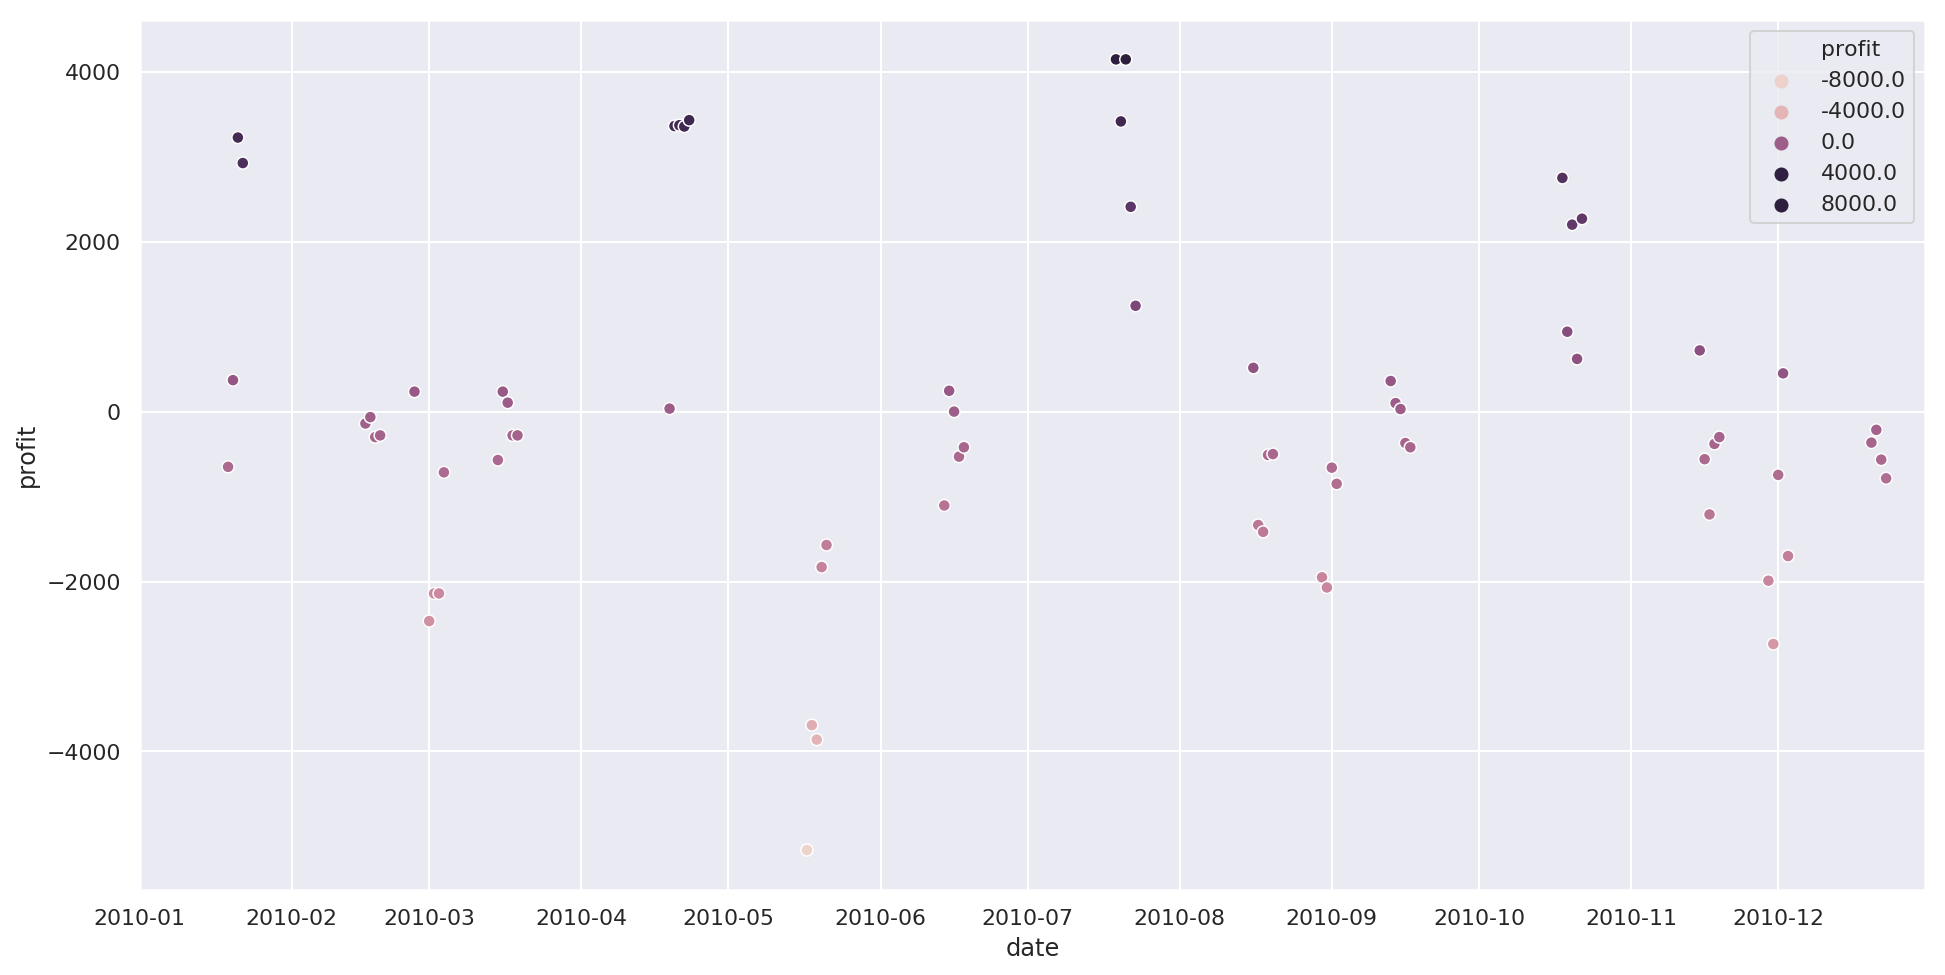

In [173]:
_fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim([pd.Timestamp(2010, 1, 1), pd.Timestamp(2010, 12, 31)])
sns.scatterplot(x=results.index, y="profit", hue="profit", data=results, ax=ax)

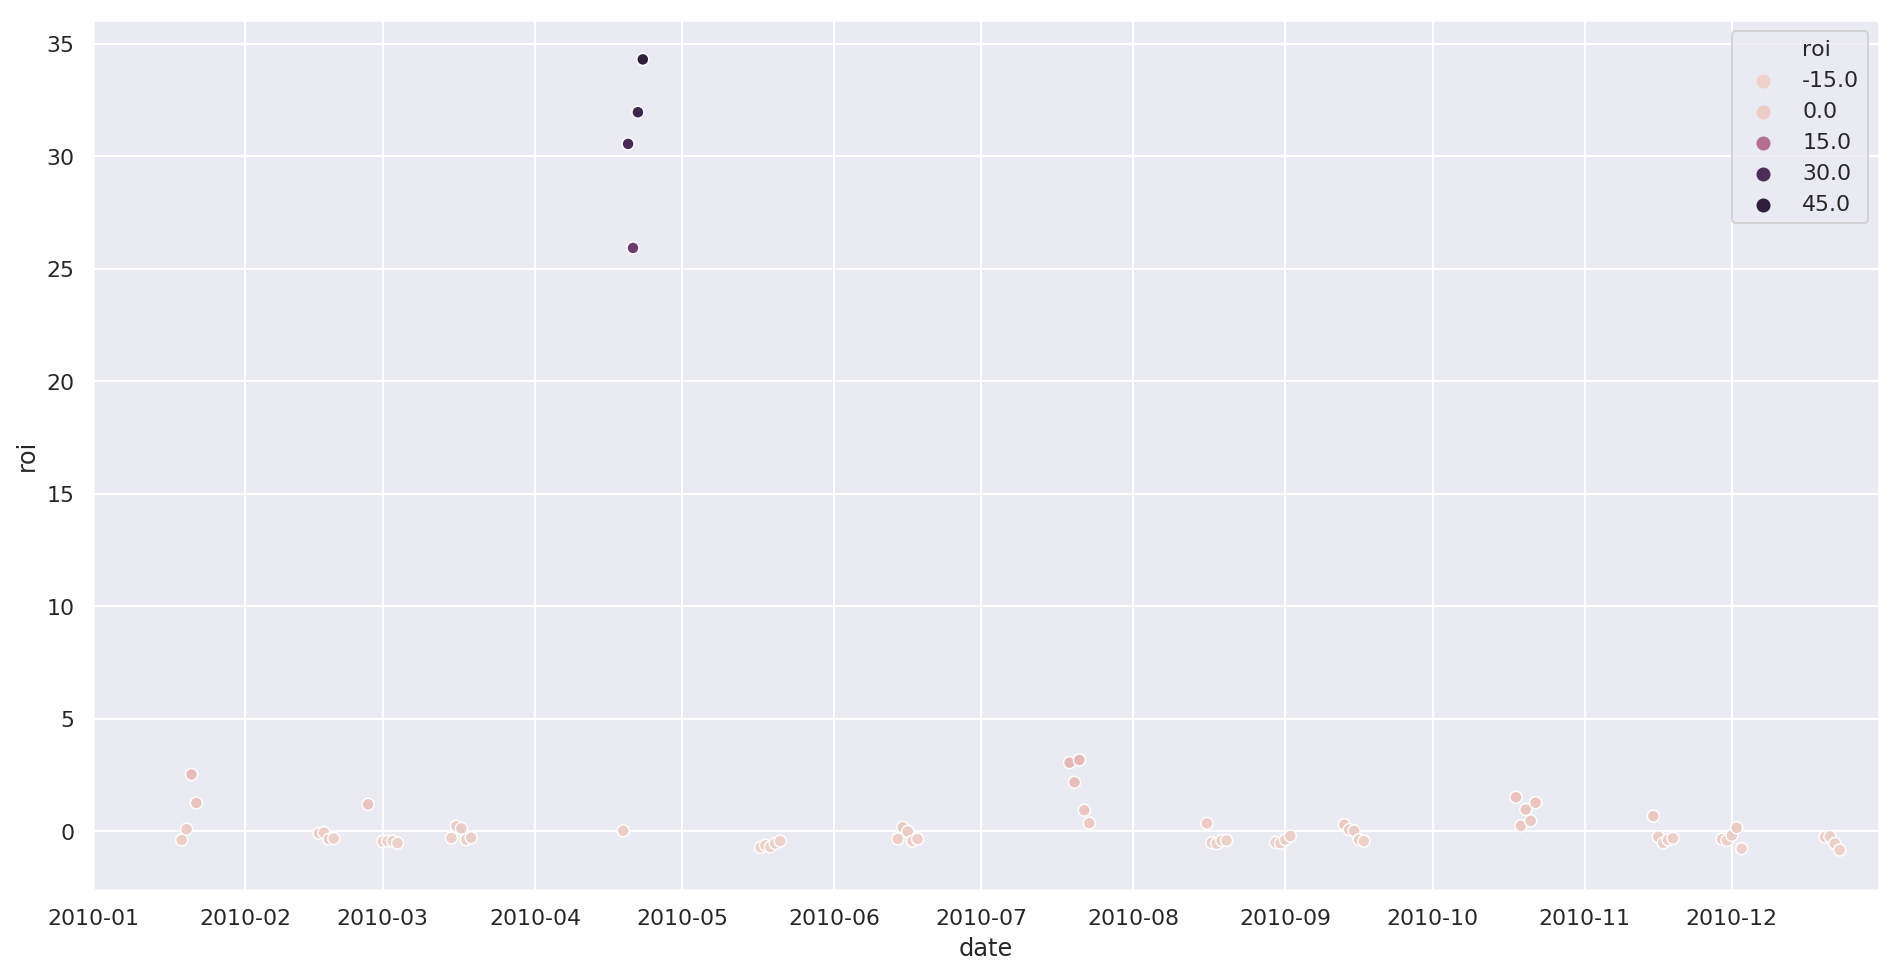

In [174]:
_fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim([pd.Timestamp(2010, 1, 1), pd.Timestamp(2010, 12, 31)])
sns.scatterplot(x=results.index, y="roi", hue="roi", data=results, ax=ax)

## Running Iron Butterflies over all data

Let's try running iron butterfly over all available data (from 1990 to 2018).

In [5]:
all_data = pd.read_hdf("../data/options_data_v2.h5", key="/SPX")

In [6]:
results = iron_butterfly(all_data)

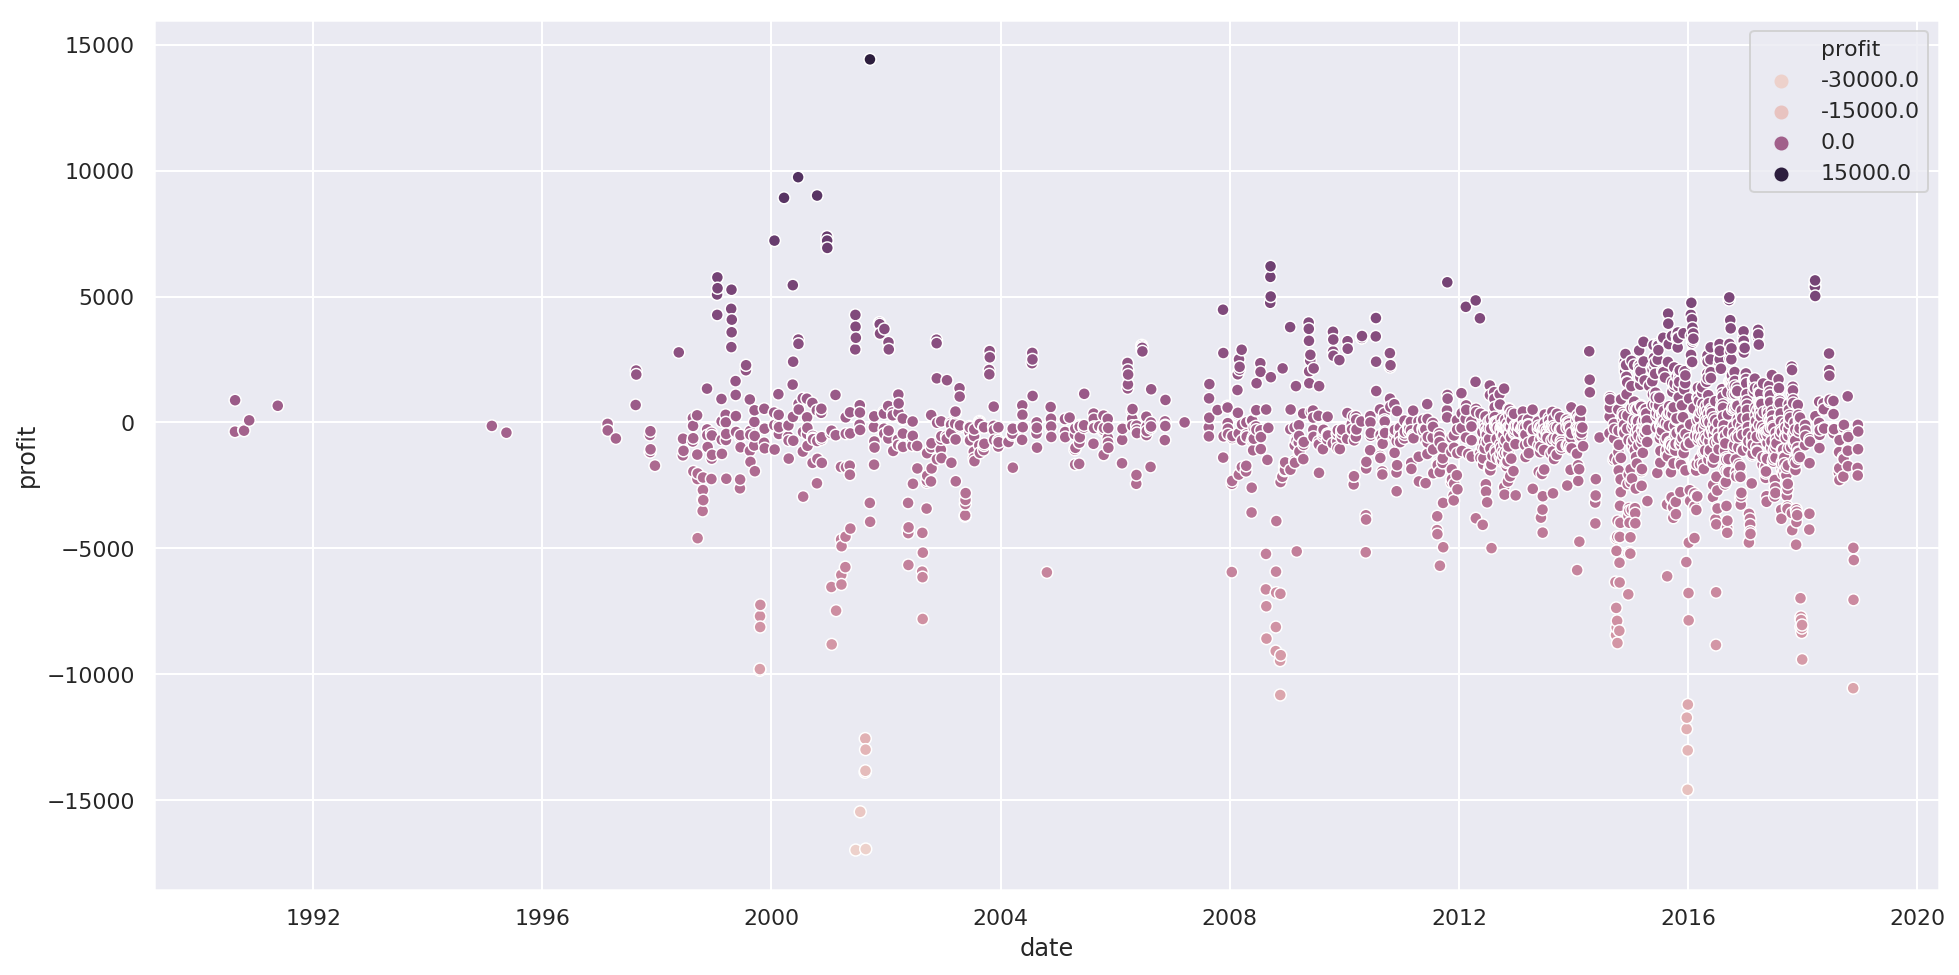

In [7]:
_fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(x=results.index, y="profit", hue="profit", data=results, ax=ax)

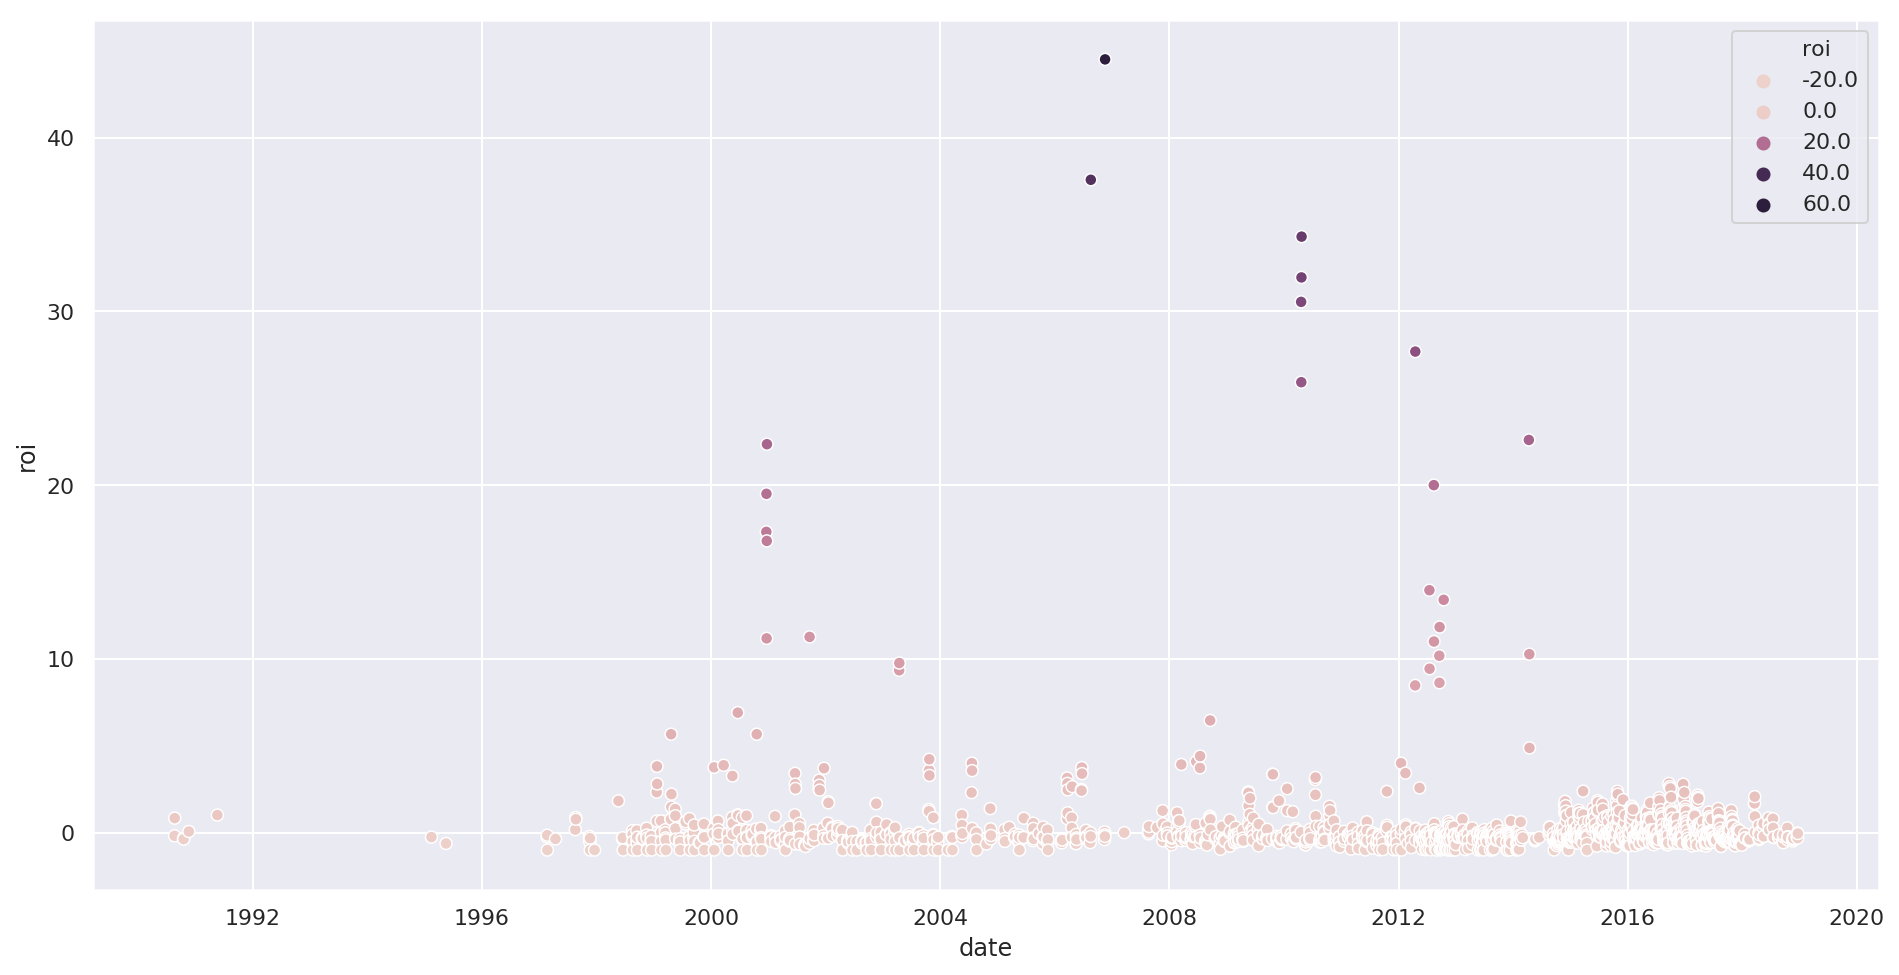

In [8]:
_fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(x=results.index, y="roi", hue="roi", data=results, ax=ax)